In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
encoding = 'normalize'
auc_results_df = pd.read_csv(f'./XGboost_100_three_models/{encoding}/auc_results_df.csv', index_col=0)
feature_importance_results_df= pd.read_csv(f'./XGboost_100_three_models/{encoding}/feature_importance_results_df.csv', index_col=0)
c_index_results_df= pd.read_csv(f'./XGboost_100_three_models/{encoding}/c_index_results_df.csv', index_col=0)
discrimination_slope_results_df = pd.read_csv(f'./XGboost_100_three_models/{encoding}/discrimination_slope_results_df.csv', index_col=0)
calibration_slope_results_df = pd.read_csv(f'./XGboost_100_three_models/{encoding}/calibration_slope_results_df.csv', index_col=0)


In [3]:
# Compute the mean and standard deviation for the ROC curves and feature importance
# For the AUC values:
roc_mean_std = auc_results_df.groupby(['model', 'fpr']).agg(
    mean_tpr=pd.NamedAgg(column='tpr', aggfunc='mean'),
    std_tpr=pd.NamedAgg(column='tpr', aggfunc='std'),
    mean_auc=pd.NamedAgg(column='auc', aggfunc='mean'),
    std_auc=pd.NamedAgg(column='auc', aggfunc='std')
).reset_index()
roc_mean_std['model'] = roc_mean_std['model'].replace(r'PredMetS', 'GenMetS', regex=True)

# 
# For the feature importances:
feature_mean_std = feature_importance_results_df.groupby(['model', 'feature']).agg(
    mean_importance=pd.NamedAgg(column='feature_importance', aggfunc='mean'),
    std_importance=pd.NamedAgg(column='feature_importance', aggfunc='std')
).reset_index()
feature_mean_std['model'] = feature_mean_std['model'].replace(r'PredMetS', 'GenMetS', regex=True)
feature_mean_std['feature'] = feature_mean_std['feature'].replace(r'PredMetS', 'GenMetS', regex=True)
c_index_mean_std = c_index_results_df.groupby(['model']).agg(
    mean_c_index=pd.NamedAgg(column='c_index', aggfunc='mean'),
    std_c_index=pd.NamedAgg(column='c_index', aggfunc='std'),
).reset_index()
c_index_mean_std['model'] = c_index_mean_std['model'].replace(r'PredMetS', 'GenMetS', regex=True)

In [4]:
auc_results_df.auc.max()

0.8341747146619842

In [5]:
feature_mean_std[feature_mean_std.model == 'GenMetS + covariates']

,model,feature,mean_importance,std_importance
2,GenMetS + covariates,Age,0.370566,0.138184
3,GenMetS + covariates,Education,0.044181,0.042428
4,GenMetS + covariates,GenMetS,0.158866,0.085404
5,GenMetS + covariates,PhysicalActivity,0.031155,0.038289
6,GenMetS + covariates,Sleephour,0.011357,0.019245
7,GenMetS + covariates,SocialEconomicalStatus,0.095920,0.068194
8,GenMetS + covariates,TVhour,0.049280,0.046547


In [6]:
c_index_mean_std

,model,mean_c_index,std_c_index
0,GenMetS + age,0.703538,0.047352
1,GenMetS + covariates,0.708695,0.045462
2,GenMetS only,0.581054,0.042939


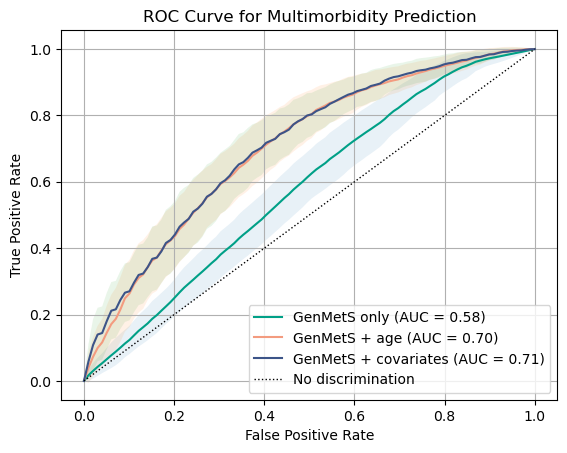

In [7]:
models = [roc_mean_std['model'].unique()[2], roc_mean_std['model'].unique()[0], roc_mean_std['model'].unique()[1]]
model_colors = {models[2]: '#3C5488FF',
    models[1]: '#F39B7FFF', 
        models[0]: '#00A087FF'
}
def plot_mean_roc_with_shade(df, filename, title):
    # plt.figure(figsize=(10, 6))
    models = [df['model'].unique()[2], df['model'].unique()[0], df['model'].unique()[1]]
    for model in models:
        data = df[df['model'] == model]
        color = model_colors[model]
        plt.plot(data['fpr'], data['mean_tpr'], label=f'{model} (AUC = {data["mean_auc"].mean():.2f})', color = color)
        plt.fill_between(data['fpr'], data['mean_tpr'] - data['std_tpr'], data['mean_tpr'] + data['std_tpr'], alpha=0.1)
    
    plt.plot([0, 1], [0, 1], ":k", label="No discrimination", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.title(title)
    plt.grid(True)
    plt.savefig(f'./figures/{filename}.pdf', bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f'./figures/{filename}.tiff', bbox_inches='tight', dpi=300, format='tiff')
    plt.savefig(f'./figures/{filename}.jpg', bbox_inches='tight', dpi=300, format='jpg')
    plt.show()

# Now call the plotting function for ROC curve with all models
plot_mean_roc_with_shade(roc_mean_std, filename='ROC_XGboost_100_age', title="ROC Curve for Multimorbidity Prediction")

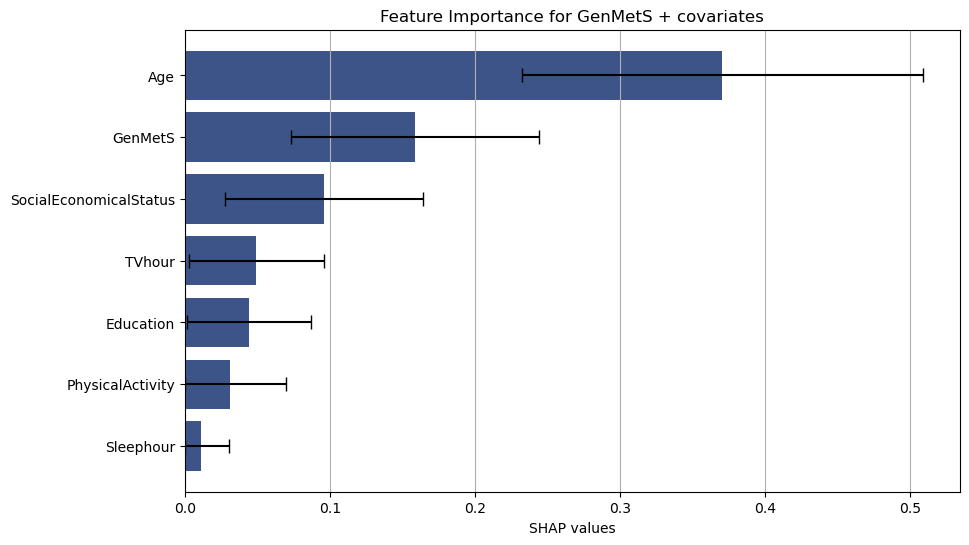

In [8]:
def plot_mean_importance_with_std_bar(df, model_name, filename, title):
    data = df[df['model'] == model_name].sort_values(by='mean_importance', ascending=True)
    plt.figure(figsize=(10, 6))
    # palette = sns.color_palette("viridis", n_colors=len(data['feature']))
    
    # Compute custom error bounds
    lower_error = np.where(data['mean_importance'] - data['std_importance'] < 0, 
                           data['mean_importance'], 
                           data['std_importance'])
    
    upper_error = data['std_importance']
    asymmetric_error = [lower_error, upper_error]

    plt.barh(data['feature'], data['mean_importance'], xerr=asymmetric_error, 
             capsize=5, color= '#3C5488FF')
    plt.title(title)
    # plt.ylabel('Feature')
    plt.xlabel('SHAP values')
    plt.grid(True, which='both', axis='x')
    plt.savefig(f'./figures/{filename}.pdf', bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f'./figures/{filename}.tiff', bbox_inches='tight', dpi=300, format='tiff')
    plt.savefig(f'./figures/{filename}.jpg', bbox_inches='tight', dpi=300, format='jpg')
    plt.show()
    plt.show()

# Now call the plotting function for feature importance separately for each model
plot_mean_importance_with_std_bar(feature_mean_std, 'GenMetS + covariates', filename='Feature_Importance_GenMetS_cov', title='Feature Importance for GenMetS + covariates')
# plot_mean_importance_with_std_bar(feature_mean_std, 'covariates only', filename='Feature_Importance_cov_Oct2', title='Feature Importance for covariates only')
